# THE PLAN: RESHAPE INTO [num_samples, 64, 2, 2]
# Then apply angle encoding to each 2x2 square to turn it into quantum states
# Then scramble the vectors with haar random unitaries
# Then convert each 2x2 matrix into 64 bloch vectors 
# Total of num_samples * 64 vectors

In [1]:
from scipy.stats import unitary_group
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pennylane as qml
from pennylane.templates import RandomLayers

import torch
import torch.nn as nn
import torch.optim as optim

(100000, 16, 16)
torch.Size([100, 8, 8, 4])


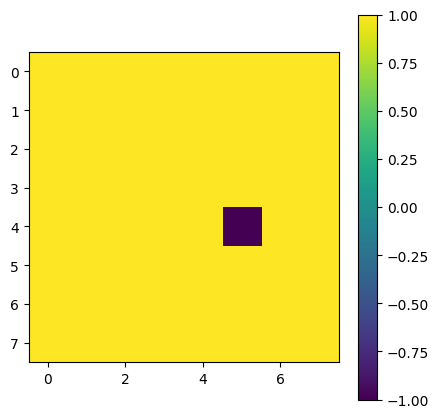

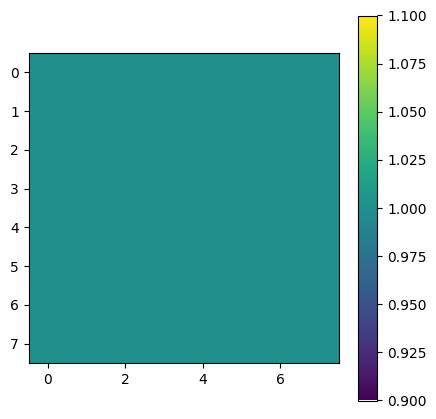

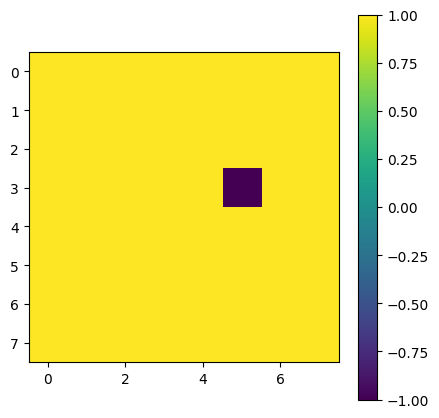

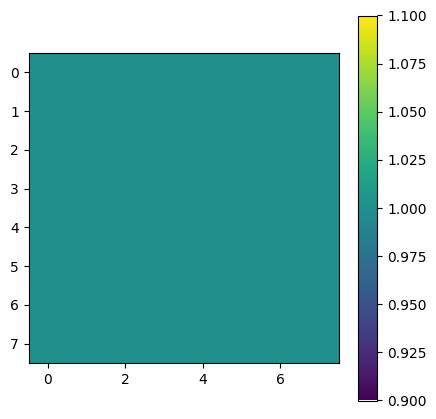

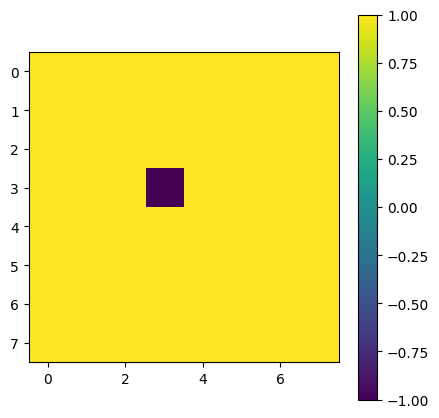

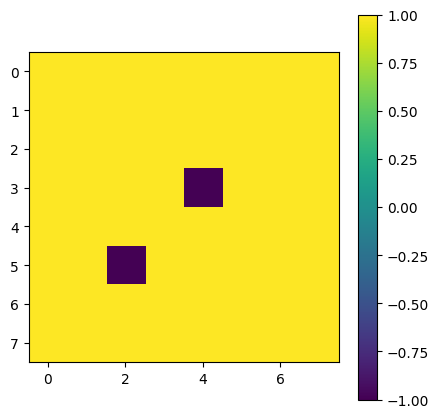

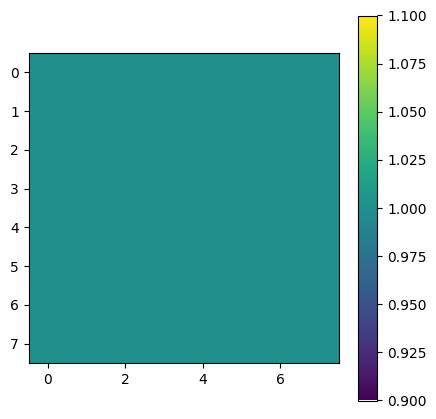

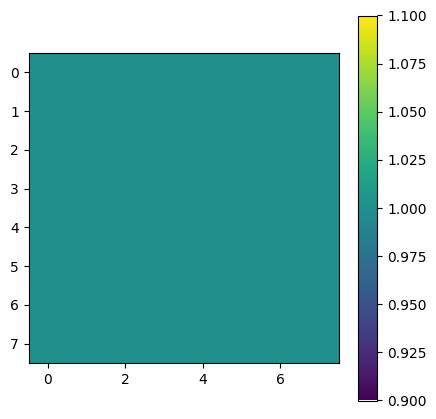

torch.Size([100, 8, 8, 4])


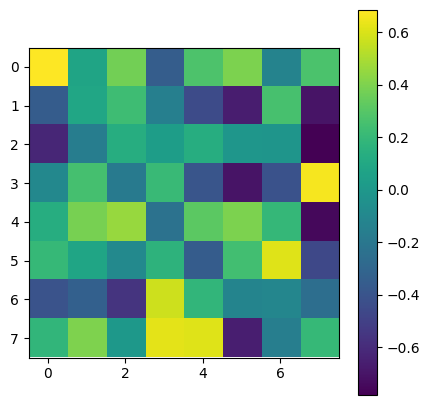

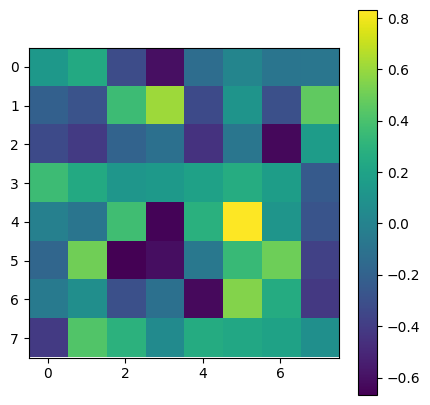

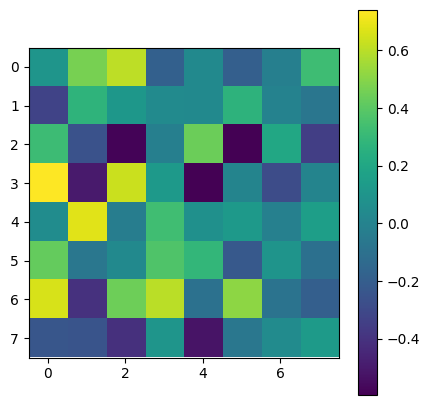

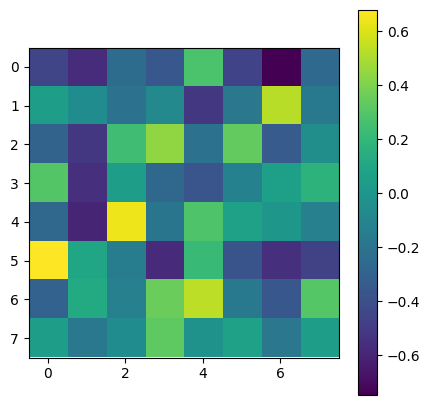

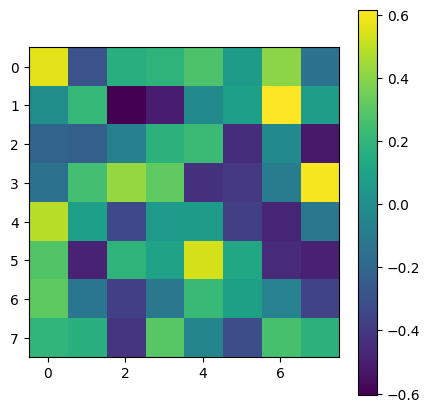

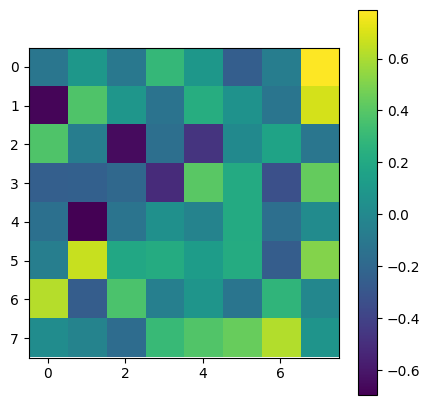

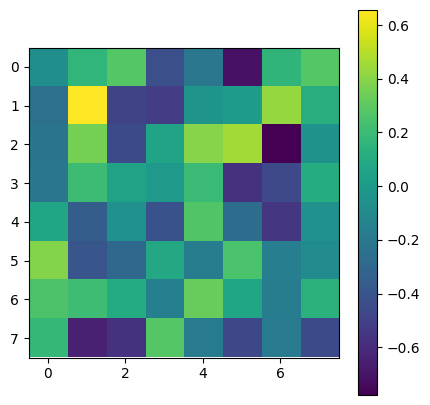

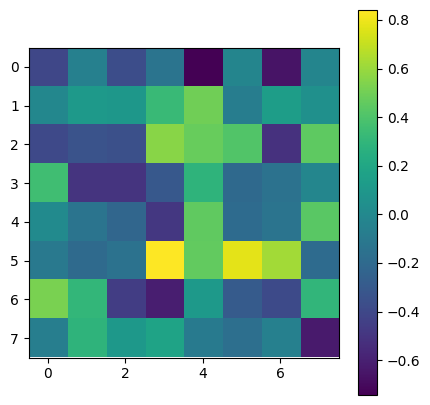

In [47]:
filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100
seed = 42

num_qubits = 64
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def angle_circuit(phi):
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def angle_encoding(data, sample=0):
    out = np.zeros((8, 8, 4))
    for i in range(0, 16, 2):
        for j in range(0, 16, 2):
            q_results = angle_circuit(
                [
                    data[sample, i, j],
                    data[sample, i, j+1],
                    data[sample, i+1, j],
                    data[sample, i+1, j+1]
                ]
            )
            for c in range(4):
                out[i//2, j//2, c] = q_results[c]
    return out

def visualize_encoded_data(encoded_data, sample_index=0):
    encoded_sample = encoded_data[sample_index]

    for channel in range(4):
        encoded_image = encoded_sample[:, :, channel]

        plt.figure(figsize=(5, 5))
        plt.imshow(encoded_image, cmap='viridis')
        # plt.title(title="QG Data")
        plt.colorbar()
        plt.show()

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(4)

def scramble_state_vectors(encoded_data, seed):
    scrambled_vectors = []

    for sample in range(num_samples):
        scrambled_vector = []
        for i in range(8):
            channels = []
            for j in range(8):
                U = haar_random_unitary(seed)
                scrambled_state = np.dot(U, encoded_data[sample, i, j, :])
                scrambled_state /= np.linalg.norm(scrambled_state)
                channels.append(scrambled_state)

                if seed is not None:
                    seed += 1
            scrambled_vector.append(channels)
        scrambled_vectors.append(scrambled_vector)

    return np.array(scrambled_vectors)


print(data_X.shape)

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = np.array(encoded_data)
encoded_data = torch.tensor(encoded_data, dtype=torch.float32)
print(encoded_data.shape)
visualize_encoded_data(encoded_data, sample_index=0)
# visualize_encoded_data(encoded_data, sample_index=1)


scrambled_states = scramble_state_vectors(np.array(encoded_data), seed)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)
visualize_encoded_data(scrambled_states, sample_index=0)
# visualize_encoded_data(scrambled_states, sample_index=1)

In [48]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])  # Connect the last qubit to the first

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out
    
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 1

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/50], Loss: 0.5653
Epoch [2/50], Loss: 0.5182
Epoch [3/50], Loss: 0.4741
Epoch [4/50], Loss: 0.4327
Epoch [5/50], Loss: 0.3940
Epoch [6/50], Loss: 0.3581
Epoch [7/50], Loss: 0.3247
Epoch [8/50], Loss: 0.2939
Epoch [9/50], Loss: 0.2656
Epoch [10/50], Loss: 0.2395
Epoch [11/50], Loss: 0.2157
Epoch [12/50], Loss: 0.1940
Epoch [13/50], Loss: 0.1744
Epoch [14/50], Loss: 0.1566
Epoch [15/50], Loss: 0.1406
Epoch [16/50], Loss: 0.1263
Epoch [17/50], Loss: 0.1135
Epoch [18/50], Loss: 0.1021
Epoch [19/50], Loss: 0.0920
Epoch [20/50], Loss: 0.0831
Epoch [21/50], Loss: 0.0752
Epoch [22/50], Loss: 0.0683
Epoch [23/50], Loss: 0.0624
Epoch [24/50], Loss: 0.0571
Epoch [25/50], Loss: 0.0526
Epoch [26/50], Loss: 0.0487
Epoch [27/50], Loss: 0.0454
Epoch [28/50], Loss: 0.0425
Epoch [29/50], Loss: 0.0401
Epoch [30/50], Loss: 0.0380
Epoch [31/50], Loss: 0.0362
Epoch [32/50], Loss: 0.0347
Epoch [33/50], Loss: 0.0334
Epoch [34/50], Loss: 0.0324
Epoch [35/50], Loss: 0.0315
Epoch [36/50], Loss: 0.0307
E

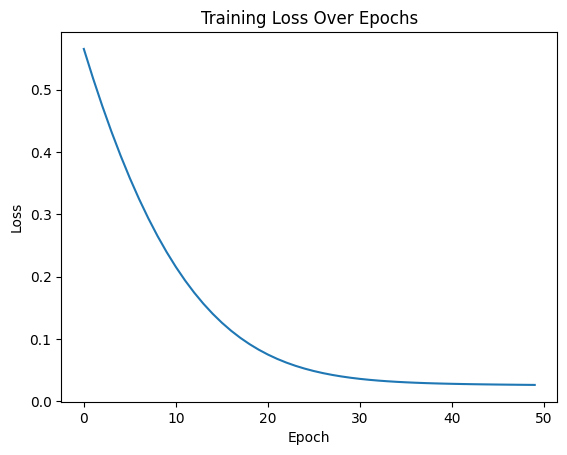

In [50]:
num_epochs = 50
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [67]:
def generate_new_samples(model, num_samples, input_dim):
    random_input = torch.randn(num_samples, input_dim)
    
    model.eval()
    
    with torch.no_grad():
        generated_output = model(random_input)
    
    generated_images = generated_output.view(num_samples, 8, 8, 4).cpu().numpy()
    
    return generated_images

num_samples_to_generate = 5

generated_images = generate_new_samples(model, num_samples_to_generate, input_dim)
print(generated_images)

def visualize_generated_images(images):
    for i in range(images.shape[0]):
        for channel in range(4):
            plt.figure(figsize=(5, 5))
            plt.imshow(images[i, :, :, channel], cmap='viridis')
            plt.colorbar()
            plt.title(f'Sample {i+1}, Channel {channel+1}')
            plt.show()

# Visualize the generated images
visualize_generated_images(generated_images)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x100 and 256x128)

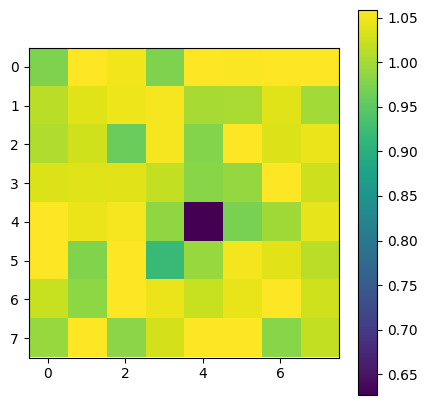

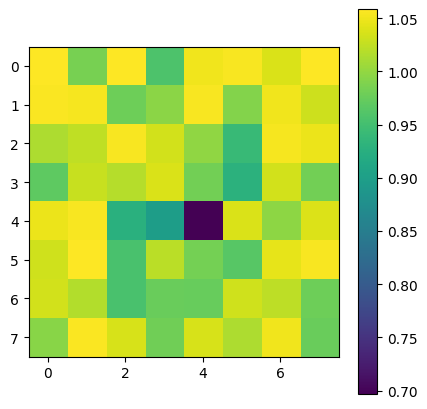

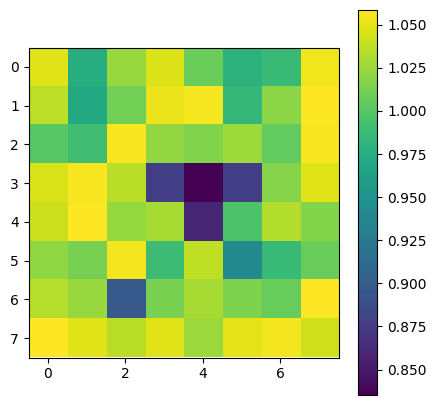

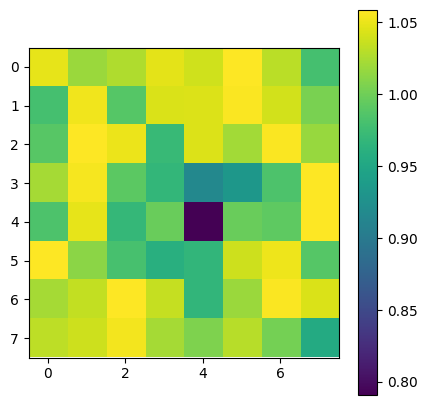

In [58]:
denoised_states = model(scrambled_states.view(num_samples, -1))
denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
visualize_encoded_data(denoised_states, sample_index=10)

(100, 8, 8, 4)
(100000, 16, 16)
(100, 16, 16)


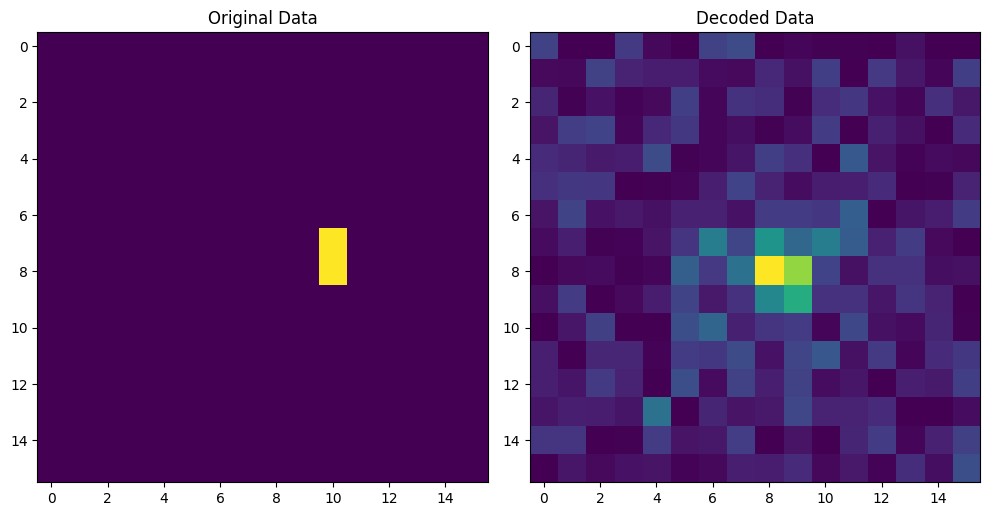

In [54]:
print(denoised_states.shape)
print(data_X.shape)

# Decode [num_samples, 8, 8, 4] into 1 channel [num_samples, 16, 16]
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

decoded_data = decode(denoised_states)
decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_data(data_X, decoded_data, sample_index=0)

In [57]:
import scipy.linalg

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):

    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

flat_data_X = data_X.reshape(data_X.shape[0], -1)
flat_decoded_data = decoded_data.reshape(decoded_data.shape[0], -1)

FID score: 2.1336417556328473


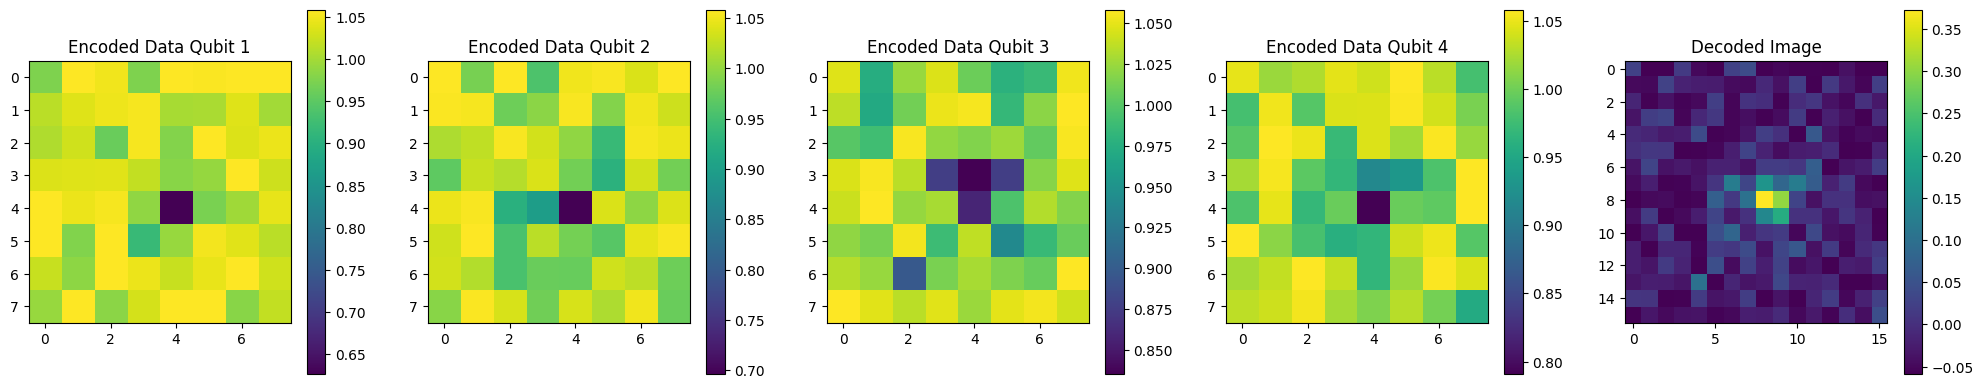

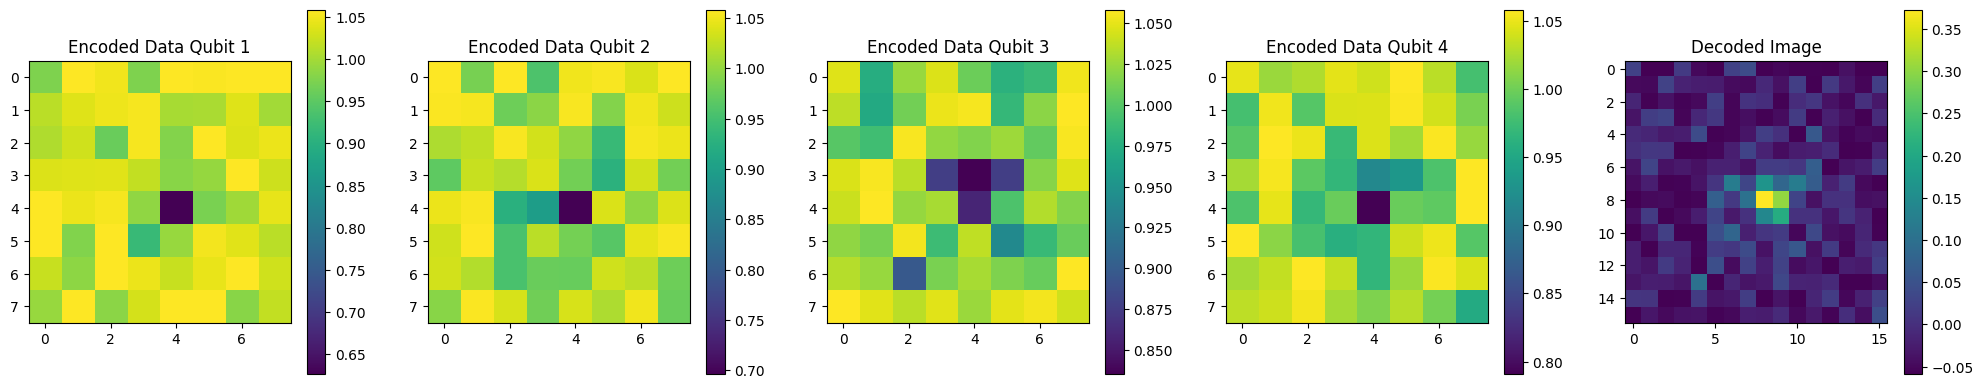

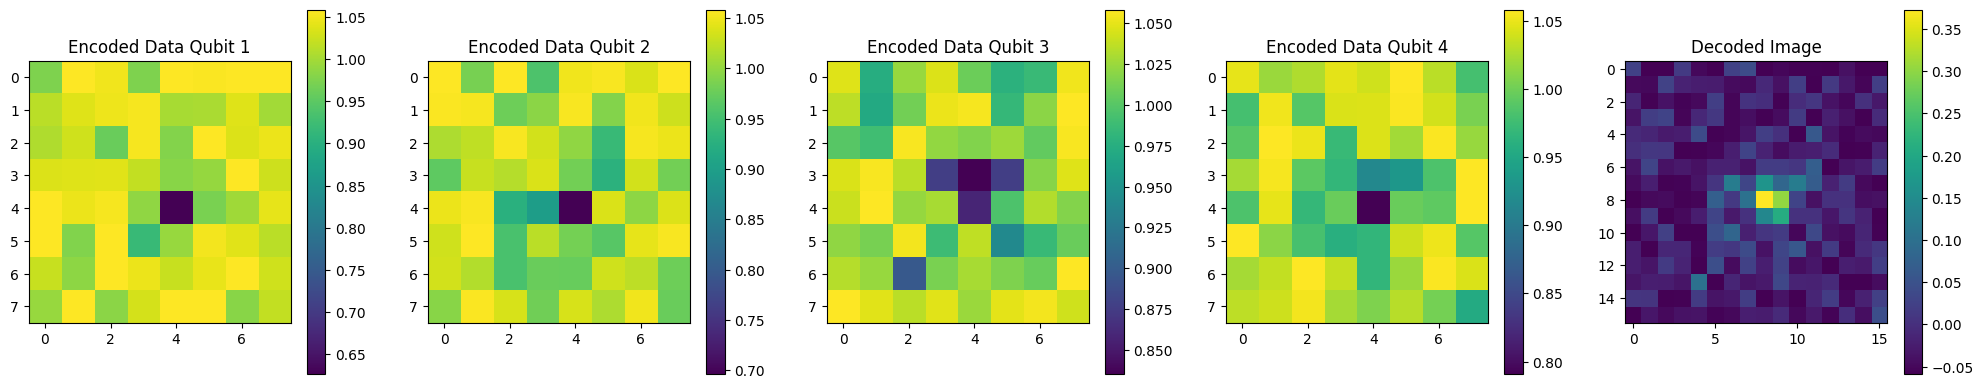

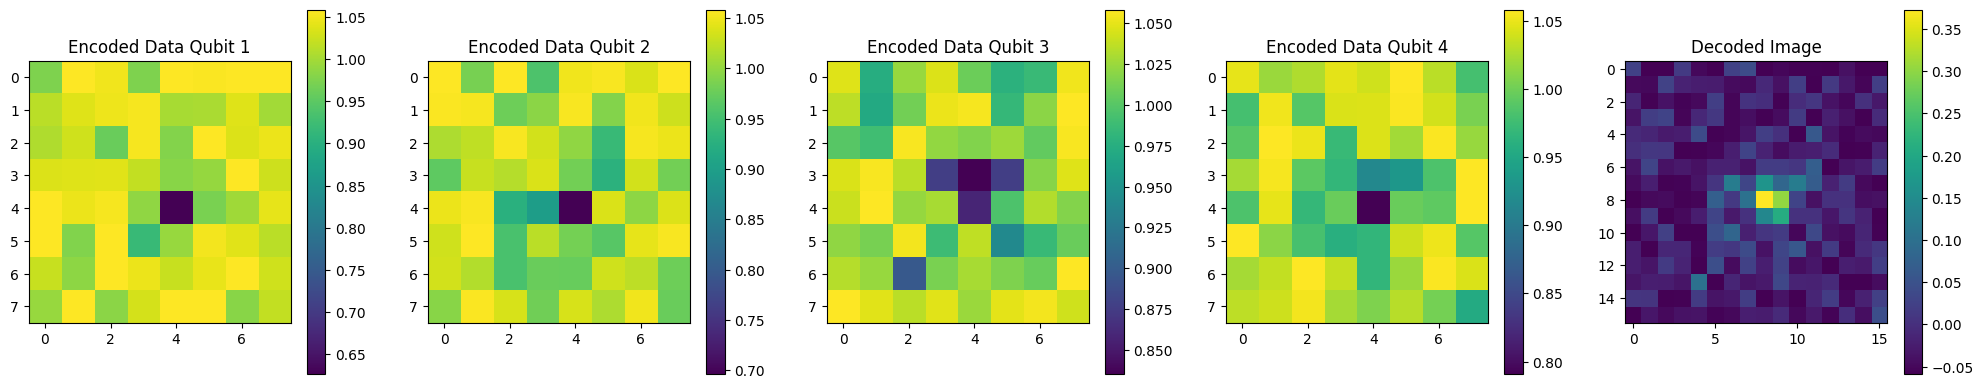

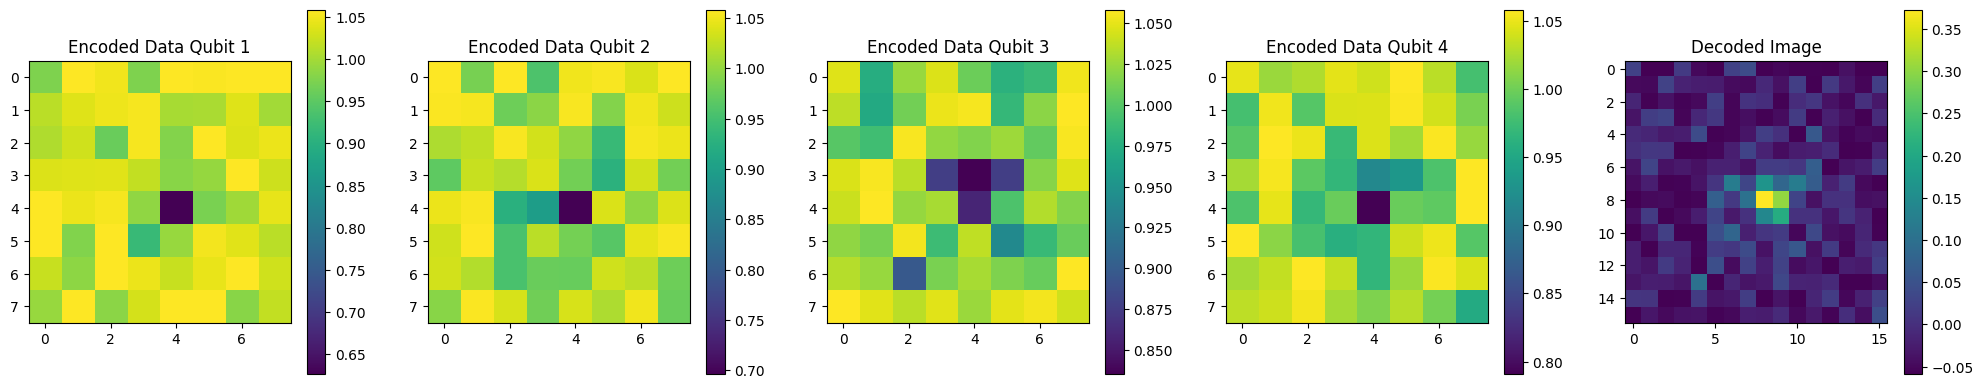

In [56]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded Data Qubit {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded Image")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images


num_new_images = 5
new_images = generate_new_images(model, num_new_images)